In [ ]:
!pip install -q yfinance

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import torch
from datetime import datetime
from torch.utils.data import DataLoader, Dataset
from sklearn import preprocessing

## Downloading data from Yahoo! Finance

In [2]:
# Apple, Google, Meta, Tesla, Walmart, United Healthcare
company_list = ['AAPL', 'GOOG', 'META', 'TSLA', 'WMT', 'UNH']

In [3]:
df = []

end_time = datetime.now()
start_time = datetime(end_time.year - 1, end_time.month, end_time.day)

for company in company_list:
  temp_df = yf.download(company, start_time, end_time)
  temp_df['name'] = company
  df.append(temp_df)

df = pd.concat(df, axis=0)
df

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,name
Date,,,,,,,
2022-12-12,142.699997,144.500000,141.059998,144.490005,143.686859,70462700,AAPL
2022-12-13,149.500000,149.970001,144.240005,145.470001,144.661423,93886200,AAPL
2022-12-14,145.350006,146.660004,141.160004,143.210007,142.413986,82291200,AAPL
2022-12-15,141.110001,141.800003,136.029999,136.500000,135.741257,98931900,AAPL
2022-12-16,136.690002,137.649994,133.729996,134.509995,133.762329,160156900,AAPL
...,...,...,...,...,...,...,...
2023-12-04,548.260010,551.869995,543.039978,548.280029,548.280029,2709200,UNH
2023-12-05,549.099976,552.530029,545.349976,550.260010,550.260010,2645600,UNH
2023-12-06,547.559998,551.880005,547.099976,549.530029,549.530029,2239700,UNH


## Understanding our data

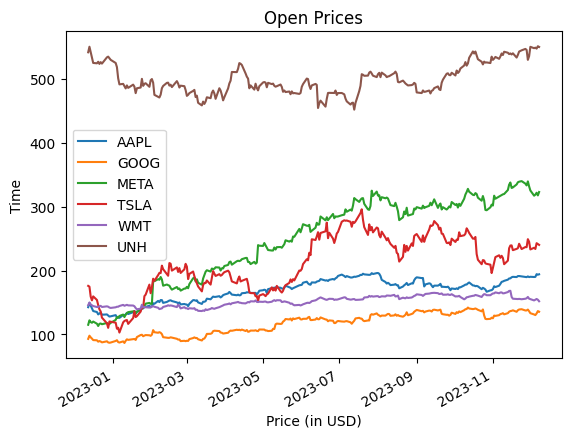

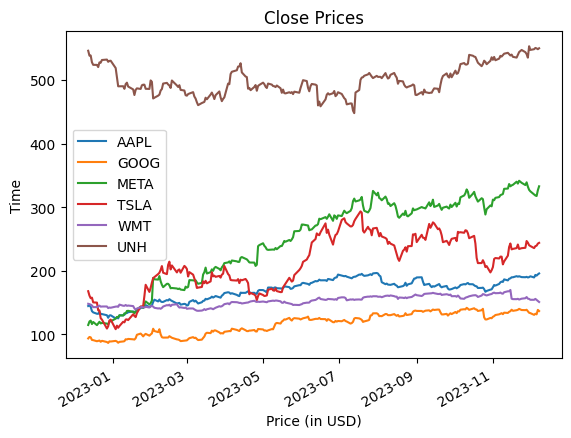

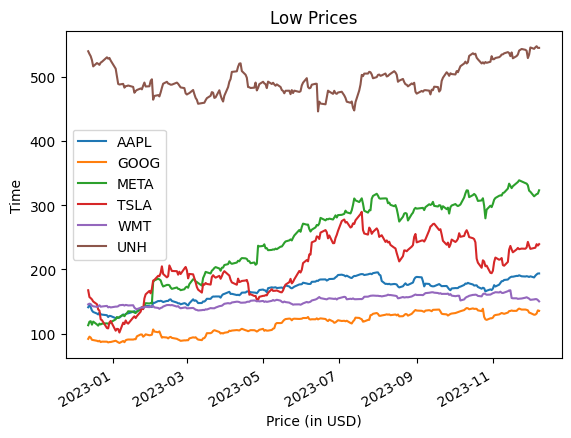

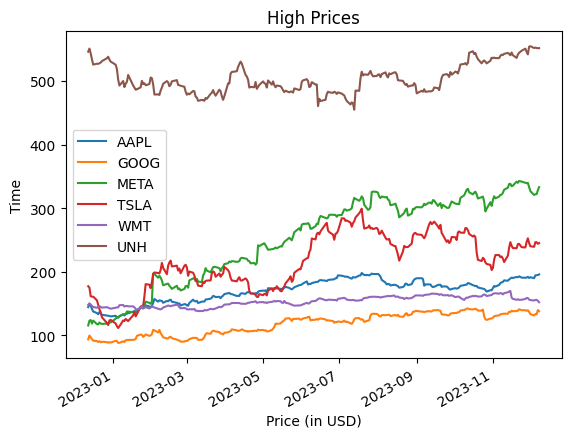

In [4]:
for feature in ['Open', 'Close', 'Low', 'High']:
  for company in company_list:

    temp_df = df[df['name'] == company]

    temp_df[feature].plot(label=f'{company}')


  plt.title(f'{feature} Prices')
  plt.xlabel('Price (in USD)')
  plt.ylabel('Time')

  plt.legend()
  plt.show()


## Preparing Data (For closing price prediction)

In [5]:
def getTrainTestSplit(df, stock_name, history_time):


  google_df = df[df['name']==stock_name].filter(['Close']).to_numpy()
  google_df = google_df.reshape(google_df.shape[0])

  scaler = preprocessing.MinMaxScaler()
  google_df = scaler.fit_transform(google_df)

  google_train = np.array(google_df[:int(0.8 * len(google_df))])
  google_val = np.array(google_df[int(0.8 * len(google_df)):])

  google_training_X = []
  google_training_Y = []

  for i in range(history_time, google_train.shape[0]):

      google_training_X.append(google_val[i-history_time:i])
      google_training_Y.append(google_val[i])

  train_df = pd.DataFrame(google_training_X)
  train_df['next day close'] = np.array(google_training_Y)

  google_testing_X = []
  google_testing_Y = []

  for i in range(history_time, google_val.shape[0]):

      google_testing_X.append(google_val[i-history_time:i])
      google_testing_Y.append(google_val[i])

  google_testing_X = np.array(google_testing_X)
  google_testing_Y = np.array(google_testing_Y)

  test_df = pd.DataFrame(google_testing_X)
  test_df['next day close'] = np.array(google_testing_Y)

  return train_df, test_df, scaler

In [6]:
def getStockData(df, stock_name, history_time):

  google_df = df[df['name']==stock_name].filter(['Close']).to_numpy()
  google_df = google_df.reshape(google_df.shape[0])

  google_train = np.array(google_df[:int(0.8 * len(google_df))])
  google_val = np.array(google_df[int(0.8 * len(google_df)):])

  google_training = []


  for i in range(history_time, google_train.shape[0]):
      samples = torch.tensor((google_train[i-history_time:i]))
      labels = torch.tensor(google_train[i])
      google_training.append((samples, labels))


  google_validation = []
  for i in range(history_time, google_val.shape[0]):
      samples = torch.tensor((google_val[i-history_time:i]))
      labels = torch.tensor(google_val[i])
      google_validation.append((samples, labels))

  return google_training, google_validation




  # google_traning_X = torch.tensor(google_traning_X)
  # google_traning_Y = torch.tensor(google_traning_Y)

  # # train_df = pd.DataFrame(google_traning_X)
  # # train_df['next day close'] = np.array(google_traning_Y)

  # train_df = [()]

  # google_testing_X = []
  # google_testing_Y = []

  # for i in range(history_time, google_val.shape[0]):

  #     google_testing_X.append(google_val[i-history_time:i])
  #     google_testing_Y.append(google_val[i])

  # google_testing_X = np.array(google_testing_X)
  # google_testing_Y = np.array(google_testing_Y)

  # test_df = pd.DataFrame(google_testing_X)
  # test_df['next day close'] = np.array(google_testing_Y)

  # return train_df, test_df

In [7]:
def convert_df_to_tensor(df):
    pass

In [8]:
history_time = 30
google_train, google_test = getStockData(df, 'GOOG', history_time)
print(len(google_train))

170


## Training a model for on Google stock opening price

In [9]:
import torch.nn as nn
class stockPricePredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm1 = nn.LSTM(input_size=history_time, hidden_size=128, num_layers=1, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=64, num_layers=1, batch_first=True)
        self.linear1 = nn.Linear(64, 25)
        self.linear2 = nn.Linear(25, 1)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = self.linear1(x)
        x = self.linear2(x)
        return x

In [10]:
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample, label = self.data[index]
        return sample.float(), label.float()

google_train, google_test = getStockData(df, 'GOOG', history_time)
stock_dataset = CustomDataset(google_train)

# Create a DataLoader
batch_size = 8
shuffle = True  # Set to True for training data, False for validation/test data
data_loader = DataLoader(stock_dataset, batch_size=batch_size, shuffle=shuffle)

def train_model(model, dataloader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        for inputs, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()

        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}')

def predict(model, input_tensor):
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
    return output.numpy()


In [11]:
model = stockPricePredictor()
optimizer = torch.optim.Adam(model.parameters())
loss_fn = nn.MSELoss()



# Define your loss function and optimizecriterion = nn.MSELoss()


# Train the model
train_model(model, data_loader, loss_fn, optimizer, num_epochs=100)


# google_train = CustomDataset(google_train)
# loader = DataLoader(google_train, shuffle=True, batch_size=8)

# n_epochs = 20
# for epoch in range(n_epochs):
#     y_pred = model(google_train[:, :30])
#     loss = loss_fn(y_pred, google_train[:, 30])
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
    # # Validation
    # if epoch % 100 != 0:
    #     continue
    # model.eval()
    # # with torch.no_grad():
    # #     y_pred = model(X_train)
    # #     train_rmse = np.sqrt(loss_fn(y_pred, y_train))
    # #     y_pred = model(X_test)
    # #     test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    # print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 1/100, Loss: 14725.306640625
Epoch 2/100, Loss: 11401.34765625
Epoch 3/100, Loss: 12393.98828125
Epoch 4/100, Loss: 6186.603515625
Epoch 5/100, Loss: 6903.150390625
Epoch 6/100, Loss: 4067.79736328125
Epoch 7/100, Loss: 2820.8125
Epoch 8/100, Loss: 1812.5169677734375
Epoch 9/100, Loss: 991.8606567382812
Epoch 10/100, Loss: 205.21420288085938
Epoch 11/100, Loss: 1199.603515625
Epoch 12/100, Loss: 367.54571533203125
Epoch 13/100, Loss: 89.48544311523438
Epoch 14/100, Loss: 548.7581176757812
Epoch 15/100, Loss: 793.3738403320312
Epoch 16/100, Loss: 121.90837860107422
Epoch 17/100, Loss: 818.1405639648438
Epoch 18/100, Loss: 883.180419921875
Epoch 19/100, Loss: 691.6497802734375
Epoch 20/100, Loss: 1191.0809326171875
Epoch 21/100, Loss: 491.5159912109375
Epoch 22/100, Loss: 449.25787353515625
Epoch 23/100, Loss: 531.7734375
Epoch 24/100, Loss: 79.8255615234375
Epoch 25/100, Loss: 408.02471923828125
Epoch 26/100, Loss: 508.45233154296875
Epoch 27/100, Loss: 563.9595947265625
Epoch 28/

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import torch
from datetime import datetime
from torch.utils.data import DataLoader, Dataset
from sklearn import preprocessing
import torch.nn as nn

# Starting from this cell, I am adding all the functions that I will use in the main predict and analyze function. Some of them are redefinitions but I just thought it would be nice to have something in one place.


1. Plotting function

In [13]:
# New Function
def visualize_stock(df, stockname):
  for feature in ['Open', 'Close', 'Low', 'High']:
    plt.plot(df[feature], label=feature)
  plt.legend()
  plt.title(f'{stockname} Stock Prices')
  plt.show()
  return

2. Preprocessing functions

In [14]:
# Currently using the function from before. This is the one Ved finally implemented just before the model started working. Has minmax scaling implemented
# Had to refactor and rename it due to following reasons:
  # 1. The df now contains prices from only one stock
  # 2. Don't need stock_name as a parameter
  # 3. The version you finally implemented got lost because of colab and I was getting some errors
  # So I changed it somehow to make it work.
  # 4. Added a new parameter to take the train_test_ratio

# Splits into train and test datasets after applying minMax scaling
# Returns train dataset, test dataset and the scaler object
def train_test_split(df, history_time, train_test_ratio=0.8):
  df = df.filter(['Close']).to_numpy()
  scaler = preprocessing.MinMaxScaler()
  df = scaler.fit_transform(df)
  df = df.reshape(df.shape[0])

  X = []
  Y = []

  for i in range(history_time, df.shape[0]):
      X.append(df[i-history_time:i])
      Y.append(df[i])

  temp_df = pd.DataFrame(X)

  temp_df['next day close'] = np.array(Y)
  temp_df.columns = temp_df.columns.astype(str)

  train_df = pd.DataFrame(temp_df[:int(train_test_ratio * len(temp_df))])
  test_df = pd.DataFrame(temp_df[int(train_test_ratio * len(temp_df)):])

  return train_df, test_df, scaler


# Changes dataframes to list of tensors, which the LSTM requires
def change_dfs_to_lists(train_dataset, test_dataset):
    train_list = []
    test_list = []

    for i in range(train_dataset.shape[0]):
        samples = torch.tensor([train_dataset.iloc[i, j] for j in range(train_dataset.shape[1] - 1)])
        labels = torch.tensor(train_dataset.iloc[i, -1])
        train_list.append((samples, labels))

    for i in range(test_dataset.shape[0]):
        samples = torch.tensor([test_dataset.iloc[i, j] for j in range(test_dataset.shape[1] - 1)])
        labels = torch.tensor(test_dataset.iloc[i, -1])
        test_list.append((samples, labels))


    return train_list, test_list



#This class is used for labelling the samples and the output differently in the lists obtained from the previous
#function. Again, redefining it here because of convenience
class StockDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample, label = self.data[index]
        return sample.float(), label.float()


# Wrapper function for preprocessing. Returns custom train_dataset, custom dataset and the scaler object
def preprocess(df, history_time, train_test_ratio=0.8):
  train_df, test_df, scaler = train_test_split(df, history_time, train_test_ratio)
  train_list, test_list = change_dfs_to_lists(train_df, test_df)

  train_dataset = StockDataset(train_list)
  test_dataset = StockDataset(test_list)
  return train_dataset, test_dataset, scaler

3. The LSTM

In [15]:
# Mostly the same, just changed the constructor to take history_time as a parameter
class stockPricePredictor(nn.Module):
    def __init__(self, history_time):
        super().__init__()
        self.lstm1 = nn.LSTM(input_size=history_time, hidden_size=128, num_layers=1, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=64, num_layers=1, batch_first=True)
        self.linear1 = nn.Linear(64, 25)
        self.linear2 = nn.Linear(25, 1)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = self.linear1(x)
        x = self.linear2(x)
        return x

4. Training and Validation Functions

In [16]:
def train_model(model, train_dataset, test_dataset, loss_fn='MSE', optimizer='ADAM', num_epochs=100, batch_size=8, shuffle=True):
    if loss_fn == 'MSE':
        criterion = nn.MSELoss()
    elif loss_fn == 'L1':
        criterion = nn.L1Loss()


    if optimizer == 'ADAM':
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    elif optimizer == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=0.001)


    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    valloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)

    model.train()
    for epoch in range(num_epochs):
        for inputs, labels in trainloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()

        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}')

        #Validation
        if epoch % 10 != 0:
            continue
        else:
          model.eval()
          predictions = []
          targets = []
          with torch.no_grad():
              for inputs, labels in valloader:
                  outputs = model(inputs)
                  predictions.append(outputs.squeeze())
                  targets.append(labels)

          val_loss = criterion(torch.cat(predictions), torch.cat(targets))
          print("Epoch %d: val loss %.4f" % (epoch, val_loss))




5. Prediction Plotting Functions

In [17]:
def plot_predictions(model, test_dataset, scaler, stockname):
  valloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)
  predictions = []
  targets = []
  with torch.no_grad():
      for inputs, labels in valloader:
          outputs = model(inputs)

          for o in outputs:
              predictions.append(o.item())

          for t in labels:
            targets.append(t.item())

  predictions = scaler.inverse_transform(np.array(predictions).reshape(1, -1))
  targets = scaler.inverse_transform(np.array(targets).reshape(1, -1))

  plt.scatter(np.arange(len(targets[0])), targets[0], label='Actual', marker='.', color='black')
  plt.scatter(np.arange(len(predictions[0])), predictions[0], label='Predicted', marker='o', color='blue')

  for i in range(len(targets[0])):
    if predictions[0][i] > targets[0][i]:
      color = 'green'
    else:
      color = 'red'

    plt.plot([i, i], [predictions[0][i], targets[0][i]], color=color, linestyle='--', linewidth=1)

  plt.title(f'{stockname} Predicted vs Actual Prices')
  plt.ylabel(f'{stockname} Stock Price')
  plt.legend()
  plt.show()

  diff_percentage = ((targets[0] - predictions[0])/targets[0]) * 100
  plt.plot(diff_percentage)
  plt.title(f'{stockname} Percentage Difference in the Predicted Price vs the Actual Price')
  plt.ylabel("Percentage")
  plt.legend()
  plt.show()

  return


In [18]:
def analyze_and_predict(stockname='GOOG', end_time=datetime.now(), start_time=-1, history_time=30, train_test_ratio=0.8, loss_fn='MSE', optimizer='ADAM', batch_size=32, shuffle=True, num_epochs=100, samples=-1):

  # Setting start time to 1 year from endtime if endtime is not specified
  # The default value of end time is current time
  if start_time == -1:
    start_time = datetime(end_time.year - 1, end_time.month, end_time.day)

  #Printing information about the stock name, start time and end time
  print(f'Analyzing the Data for the stock {stockname}')
  print(f'Start Time: {start_time}')
  print(f'End Time: {end_time}')
  print("---------------------------------------------------------------------------------")
  print("\n \n \n")

  # Downloading the dataset

  print("Downloading the data")
  df = yf.download(stockname, start_time, end_time)
  print("---------------------------------------------------------------------------------")
  print("\n \n \n")


  # Describing the dataset in words before visualizing the data
  print(f'The data consists entries from {df.shape[0]} days')
  print("---------------------------------------------------------------------------------")
  print("The data consists of the following values: \n Open: The opening price of the stock for that day. \n Close: The closing price of the stock for that day. \n High: The highest price the stock reached during that day. \n Low: The lowest price the stock reached during that day.")
  print("---------------------------------------------------------------------------------")




  #Visualizing the Opening, Closing, High and Low Prices for the stock
  # NOTE FOR VED: I thought it made more sense to visualize all four features in one plot per stock instead of four different plots
  # so I changed the plotting function a little for it to make more concise
  print("Visualizing the data")
  print("\n \n \n")
  visualize_stock(df, stockname)
  print("\n \n \n")
  print(f'We use historic stock closing prices from the last history_time days ({history_time} in this case) as features to determine the price on a particular day')
  print("---------------------------------------------------------------------------------")
  print("\n \n \n")

  #Preprocessing data for training the model to make the dataset have history_time prices as different features and set the price of the history_time-th day as the output
  train_dataset, test_dataset, scaler = preprocess(df, history_time, train_test_ratio)

  #Initializing the model. The model uses a predefined architecture (as defined in the stockPricePredictor class)
  model = stockPricePredictor(history_time)


  #Training the model
  print("Training the model")
  print("---------------------------------------------------------------------------------")
  print("\n \n \n")
  train_model(model, train_dataset, test_dataset, loss_fn, optimizer, num_epochs, batch_size, shuffle)

  print("---------------------------------------------------------------------------------")
  print("\n \n \n")


  #Plotting our outputs and the target to visualize the accuracy of the model
  print("Plotting our outputs and the target to visualize the accuracy of the model")
  print("This plot also shows the difference in the actual stock price and our predicted price.")
  print("---------------------------------------------------------------------------------")
  print("\n \n \n")
  plot_predictions(model, test_dataset, scaler, stockname)
  print("---------------------------------------------------------------------------------")
  print("\n \n \n")

  print("As we can see from the graph above, the model performs with considerable accuracy in predicting the stock price.")
  print("---------------------------------------------------------------------------------")
  print("\n \n \n")


  if samples == -1:
    print("You did not provide any values to predict the stock price for.")
    print("---------------------------------------------------------------------------------")
    print("\n \n \n")
    print("Thank You.")
  else:
    print("Predicting the stock price for the next few days")
    print("---------------------------------------------------------------------------------")
    print("\n \n \n")


  return








Analyzing the Data for the stock AAPL
Start Time: 2022-12-10 00:00:00
End Time: 2023-12-10 00:59:40.970671
---------------------------------------------------------------------------------

 
 

[*********************100%%**********************]  1 of 1 completed
---------------------------------------------------------------------------------

 
 

The data consists entries from 250 days
---------------------------------------------------------------------------------
The data consists of the following values: 
 Open: The opening price of the stock for that day. 
 Close: The closing price of the stock for that day. 
 High: The highest price the stock reached during that day. 
 Low: The lowest price the stock reached during that day.
---------------------------------------------------------------------------------
Visualizing the data

 
 



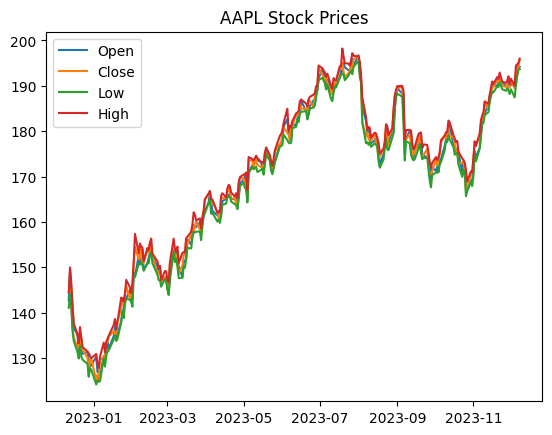


 
 

We use historic stock closing prices from the last history_time days (30 in this case) as features to determine the price on a particular day
---------------------------------------------------------------------------------

 
 

Training the model
---------------------------------------------------------------------------------

 
 

Epoch 1/80, Loss: 0.369773805141449
Epoch 0: val loss 0.3470
Epoch 2/80, Loss: 0.09818101674318314
Epoch 3/80, Loss: 0.0618913397192955
Epoch 4/80, Loss: 0.08462902903556824
Epoch 5/80, Loss: 0.052848927676677704
Epoch 6/80, Loss: 0.08234818279743195
Epoch 7/80, Loss: 0.05497792735695839
Epoch 8/80, Loss: 0.057103175669908524
Epoch 9/80, Loss: 0.03583603352308273
Epoch 10/80, Loss: 0.04150853678584099
Epoch 11/80, Loss: 0.03758688271045685
Epoch 10: val loss 0.0309
Epoch 12/80, Loss: 0.026897786185145378
Epoch 13/80, Loss: 0.023677995428442955
Epoch 14/80, Loss: 0.016040148213505745
Epoch 15/80, Loss: 0.011615938507020473
Epoch 16/80, Loss: 0.012280

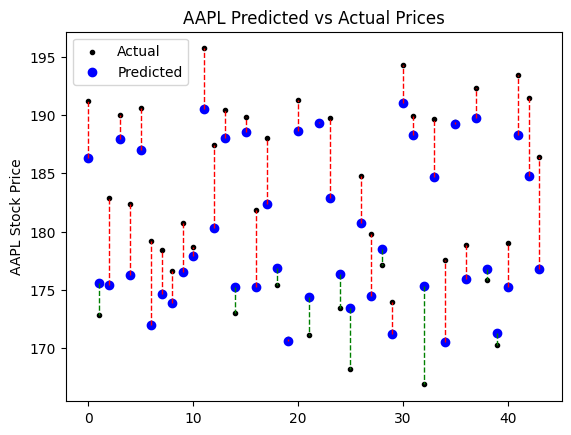

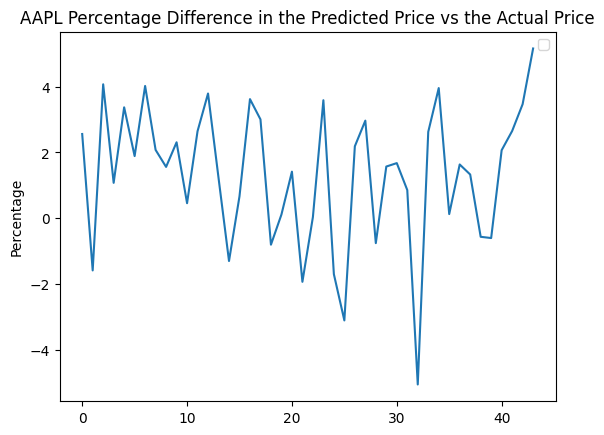

---------------------------------------------------------------------------------

 
 

As we can see from the graph above, the model performs with considerable accuracy in predicting the stock price.
---------------------------------------------------------------------------------

 
 

You did not provide any values to predict the stock price for.
---------------------------------------------------------------------------------

 
 

Thank You.


In [19]:
analyze_and_predict(stockname='AAPL', num_epochs=80)

Random forest classifier:

In [33]:
def prepRandomForestData(df, stock_name, history_time):

  google_df = df[df['name']==stock_name].filter(['Close']).to_numpy()
  #google_df = google_df.reshape(google_df.shape[0])

  scaler = preprocessing.MinMaxScaler()
  google_df = scaler.fit_transform(google_df)

  google_train = np.array(google_df[:int(0.8 * len(google_df))])
  google_val = np.array(google_df[int(0.8 * len(google_df)):])

  google_training_X = []
  google_training_Y = []

  for i in range(history_time, google_train.shape[0]):
      google_training_X.append(google_train[i-history_time:i].reshape(history_time))

      google_training_Y.append(google_train[i])

  train_df = pd.DataFrame(google_training_X)
  train_df['next day close'] = np.array(google_training_Y)

  google_testing_X = []
  google_testing_Y = []

  for i in range(history_time, google_val.shape[0]):

      google_testing_X.append(google_val[i-history_time:i].reshape(history_time))
      google_testing_Y.append(google_val[i])

  google_testing_X = np.array(google_testing_X)
  google_testing_Y = np.array(google_testing_Y)

  test_df = pd.DataFrame(google_testing_X)
  test_df['next day close'] = np.array(google_testing_Y)

  return train_df, test_df, scaler

In [81]:
from sklearn.ensemble import RandomForestRegressor

def runRFTest(stock_name, n_estimators=500):
  train_df, test_df, scaler = prepRandomForestData(df, stock_name, 30)
  X_train, Y_train = train_df.to_numpy()[:, :30], train_df.to_numpy()[:, 30]
  X_test, Y_test = test_df.to_numpy()[:, :30], test_df.to_numpy()[:, 30]

  clf = RandomForestRegressor(n_estimators=n_estimators, max_depth=10)
  clf.fit(X_train, Y_train)
  pred = clf.predict(X_test)
  #plt.scatter(scaler.inverse_transform(pred.reshape(1, -1)), scaler.inverse_transform(Y_test.reshape(1, -1)))

  errors = (scaler.inverse_transform(pred.reshape(1, -1)) - scaler.inverse_transform(Y_test.reshape(1, -1))) * 100 / scaler.inverse_transform(Y_test.reshape(1, -1))

  plt.scatter(np.arange(len(pred)), errors)

  print(np.mean(np.absolute(errors)))


Ticker AAPL
1.218086203790565


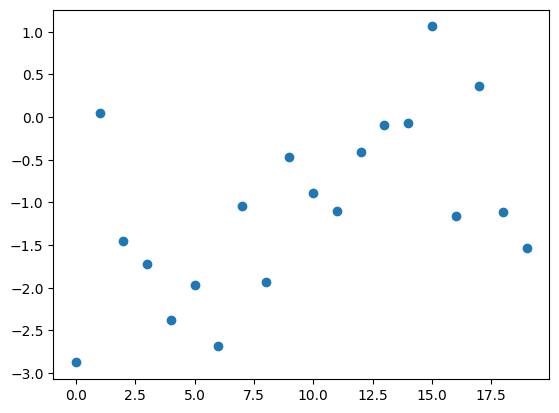

Ticker GOOG
1.1515964536094


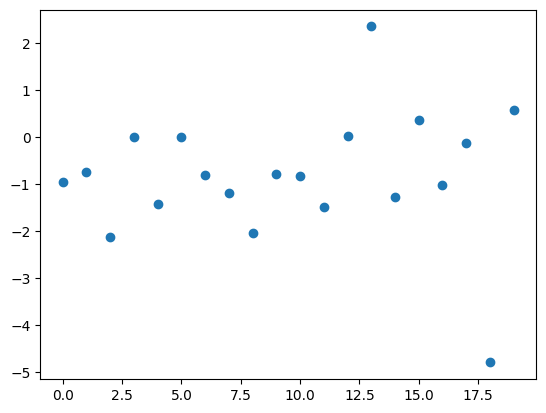

Ticker META
6.0208719781486675


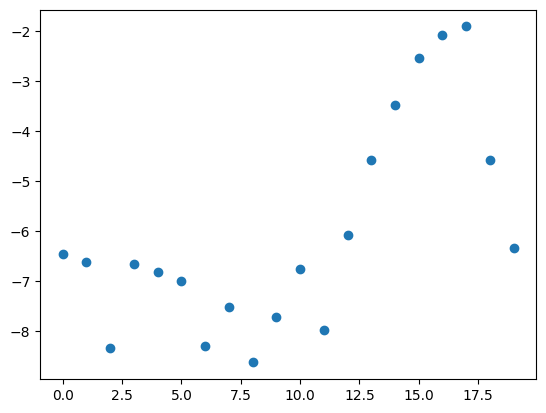

Ticker TSLA
3.1151404641418887


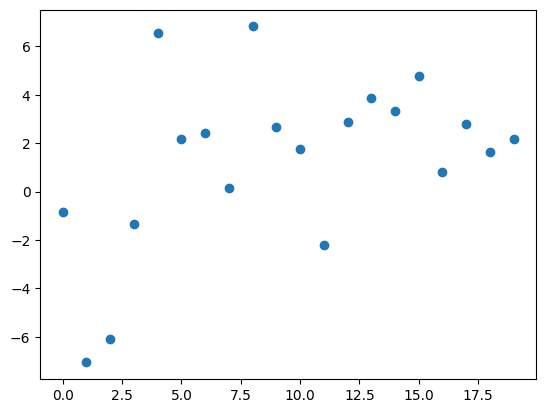

Ticker WMT
2.5634269248727284


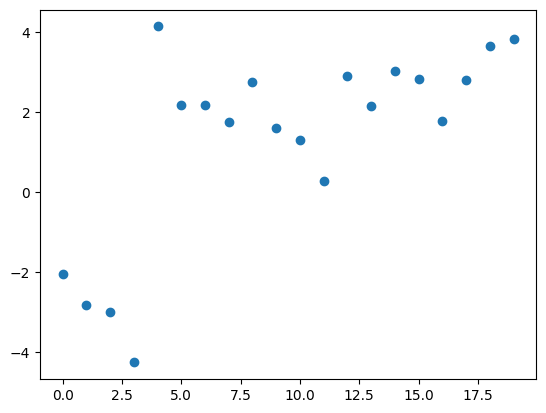

Ticker UNH
6.404375471761556


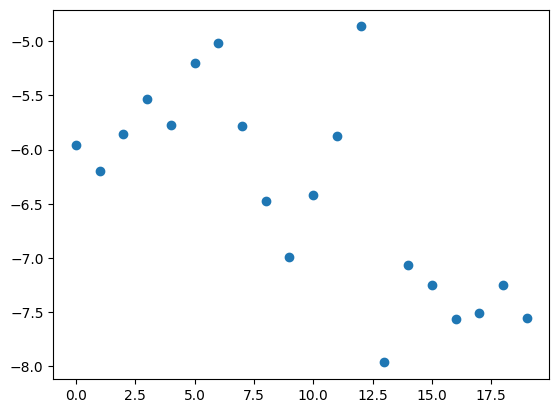

In [82]:
for ticker in ['AAPL', 'GOOG', 'META', 'TSLA', 'WMT', 'UNH']:
  print('Ticker', ticker)
  runRFTest(ticker)
  plt.show()